# Лабораторная работа "Фемптосекундный  лазер"

## В  настоящем блокноте представлена  программа для  выполнения следующих задач:<br>
### 1)Определяете период следования и частоту повторений импульсов лазера  
### 2)Определяете время нарастания фронта импульсов от 10% до 90% на обоих фотоприёмниках
### 3)Привести спектр и описать его, определить ширину спектра 
### 4)Привести среднюю мощность на выходе из лазера и кристалла, определить эффективность преобразования во 2 гармонику 
### 5)Проверить, является ли импульс спектрально ограниченным
### 6)Оценить энергию в одном импульсе
### 7)Посчитать пиковую мощность 
### 8)Посчитать пиковую интенсивность при фокусировке импульса в пятно диаметром 8 мкм

In [459]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.signal import argrelextrema
from scipy.signal import find_peaks, peak_widths,savgol_filter
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import copy
import math
from scipy.stats import t

In [460]:
data_path =  "femtosecond_laser_lab_data"
save_path = "results"

In [585]:
def unpack(path,name,delimiter):
    data = np. loadtxt(path + "\\" + name, dtype='float',delimiter=delimiter)
    return data[:,0], data[:,1]

def find_max(data, prominence, distance):
    max_ind = find_peaks(data[1],  prominence =  prominence, distance = distance)
    return [data[0][max_ind[0]],data[1][max_ind[0]], max_ind[0] ]

def calc_vlines_params(max_ind, time, max_level,  start=None):
    vlines_param = []
    peak = len(max_ind)
    for i in range(peak):
        if i == 0: 
            y_max = max([max_level[i], max_level[i + 1]]) + max_level.max() * 0.075
        elif i < peak - 1: 
            y_max = max([max_level[i - 1], max_level[i], max_level[i + 1]]) + max_level.max() * 0.1
        else:
            y_max = max([ max_level[-1], max_level[-2]]) + max_level.max() * 0.075
        if start is None:
            y_min = max_level[i]
        else:
            y_min = start
        time_coord = time[max_ind[i]]
        vlines_param.append([time_coord, y_min, y_max])
    return vlines_param

def calc_arrow_params_2(max_ind, time, max_level, arrow_head_procent, tau_step):
    arrow_params = []
    for i in range(len(max_ind ) - 1):
        arrow_high = max([max_level[i], max_level[i + 1]]) + max_level.max()  * 0.05
        arrow_center =(time[max_ind[i + 1]] + time[max_ind[i]]) / 2
        arrow_length =  (time[max_ind[i + 1]] - time[max_ind[i]]) * (arrow_head_procent - 1) / 2 
        arrow_head_length = (time[max_ind[i + 1]] - time[max_ind[i]]) * (arrow_head_procent) / 2 
        tau_time = time[max_ind[i]] + (arrow_center - time[max_ind[i]]) * tau_step 
        tau_high = max([max_level[i], max_level[i + 1]]) + max_level.max()   * 0.07
        arrow_params.append([arrow_center, arrow_high, arrow_length, arrow_head_length, tau_time, tau_high ])
    return arrow_params

def rand_error(data, conf_prob):
    mean = np.mean(data)
    n = len(data)
    student_coef = round(t.ppf((1 + conf_prob )/2, n - 1), 2)
    var = np.var(data)
    interval = student_coef * math.sqrt((var)/n)
    return [mean, interval]

def round_func(errors):
    r_errors = []
    for error in errors: 
        r_error = np.round(error, -int(math.floor(math.log10(abs(error)))))
        power = np.log10(abs(r_error))
        if r_error * 10**abs(power) == 1:
            r_error = round(error, 2-int(math.floor(math.log10(abs(error))))-1)
        r_errors.append(r_error)
    return r_errors

def get_nearest_value(n_value, array):
    result_index = np.argmin(abs(array-n_value))
    return  result_index, array[result_index]

Перед обработкой данных лучше удалить в файлах первые строки с настройками и оставить только координаты 

In [586]:
oscill_settings = ["LECROYWR44Xi, 19495, Waveform", 
                    "Segments,1,SegmentSize, 1000001",
                    "Segment,TrigTime,TimeSinceSegment1"
                    "1,05-Apr-2022 06:39:46,0"                 
                    "Time, Ampl"]

spectrometer_settings = ["Source: Spectrum Viewer"
                         "Chart: Pulse Spectrum"
                         "Series:" 
                         "Wavelength (nm)	S (a.u.)"]

In [587]:
name = ["period.txt", "rise_first_detector.txt", "rise_second_detector.txt","spectrum.dat"]

### Определим период следования и частоту повторений импульсов лазера 

In [588]:
period_time,period_signal = unpack(data_path, "period.txt",delimiter=',')
#сдвинем на 0
period_time = period_time - period_time[0]

In [589]:
#фильтрация
period_signal = savgol_filter(period_signal, 99, 3)

In [590]:
#prominence необходимо настроить для так, чтобы количество видимых на графике пиков сопадало с тем, что выдаёт функция 
max_period_time, max_period_signal, max_period_ind = find_max([period_time,period_signal], prominence=0.5, distance=300)

In [591]:
#расстояние между пиками 
interval_period = np.diff(max_period_time)

Период следования импульсов лазера в с

In [592]:
#среднее и погрешности 
#eps -относительная погрешность осциллографа
eps = 0.0005
mean_interval_period, Delta_rand_mean_interval_period = rand_error(interval_period, conf_prob=0.99)
Delta_mean_interval_period = math.sqrt(Delta_rand_mean_interval_period**2 + (mean_interval_period*eps)**2)
delta_mean_interval_period = Delta_mean_interval_period / mean_interval_period
print("Период следования импульсов лазера в с", mean_interval_period)
print("Абсолютная погрешность = ", round_func([Delta_mean_interval_period])[0])
print("Относительна погрешность = ", round_func([delta_mean_interval_period])[0],"\n")

Период следования импульсов лазера в с 0.000499154
Абсолютная погрешность =  3e-07
Относительна погрешность =  0.0005 



Период следования импульсов лазера в Гц

In [593]:
freq_interval_period = 1 / mean_interval_period
Delta_interval_period = freq_interval_period * delta_mean_interval_period
delta_interval_period = delta_mean_interval_period
print("Период следования импульсов лазера в с", freq_interval_period)
print("Абсолютная погрешность = ", round_func([Delta_interval_period])[0])
print("Относительна погрешность = ", round_func([delta_interval_period])[0],"\n")

Период следования импульсов лазера в с 2003.3897354323515
Абсолютная погрешность =  1.0
Относительна погрешность =  0.0005 



In [594]:
time_coef = 1e+3
ampl_coef = 1
# проведём стрелку только между центральными пиками 
central_peaks_ind = int(len(max_period_ind)/2)
arrow_head_width = 8e-3
vlines = calc_vlines_params(
                            max_ind=max_period_ind[central_peaks_ind-1:central_peaks_ind+1],
                            time=period_time,
                            max_level=max_period_signal[central_peaks_ind-1:central_peaks_ind+1],  
                            start=None
                           )
arrow = calc_arrow_params_2(max_ind=max_period_ind[central_peaks_ind-1:central_peaks_ind+1],
                            time=period_time,
                            max_level=max_period_signal[central_peaks_ind-1:central_peaks_ind+1], 
                            arrow_head_procent=0.1,
                            tau_step=0.4)

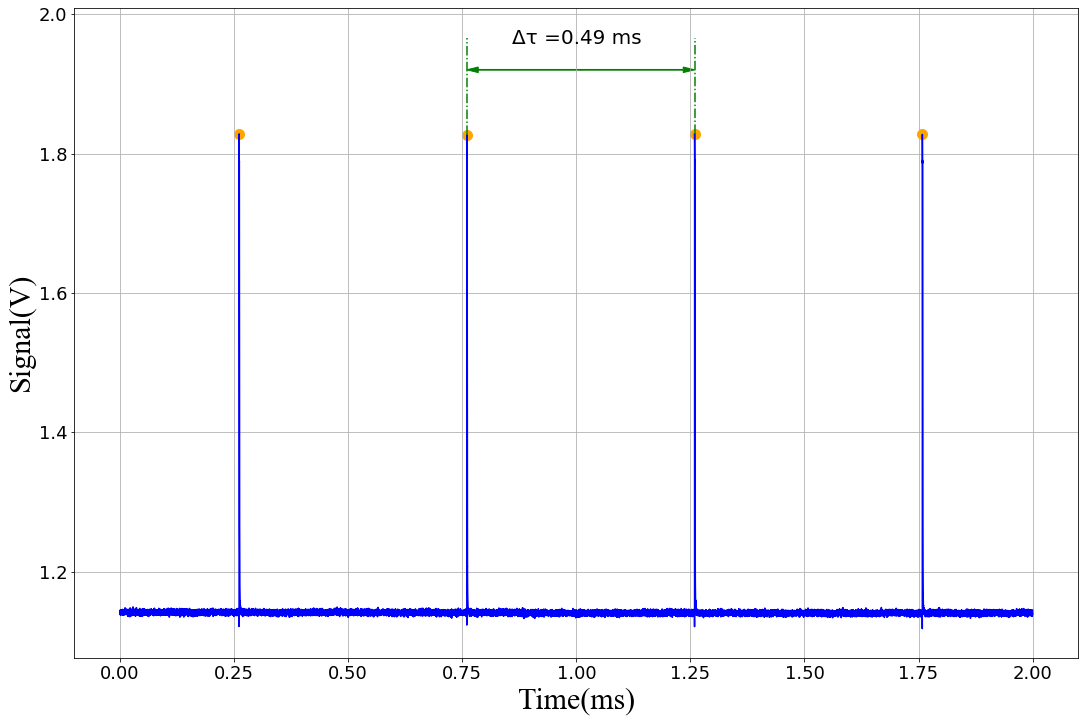

In [595]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(period_time * time_coef, period_signal*ampl_coef, c = 'blue') 
ax.set_xlabel('Time(ms)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Signal(V)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)

for i in range(len(max_period_ind)):
    ax.scatter(max_period_time[i]*time_coef, max_period_signal[i]*ampl_coef, color='orange', s=100, marker='o')
    
for i in range(2):
    ax.vlines(vlines[i][0] * time_coef, ymin = vlines[i][1] * ampl_coef, 
              ymax = vlines[i][2] * ampl_coef, color = 'green', linestyles = 'dashdot'
              )
    
ax.arrow(
          arrow[0][0] * time_coef,  arrow[0][1] * ampl_coef, + arrow[0][2] * time_coef, 0,
          head_width=arrow_head_width * ampl_coef, head_length=arrow[0][3] * time_coef, color = 'g'
            )
ax.arrow(
          arrow[0][0] * time_coef,  arrow[0][1] * ampl_coef, -arrow[0][2] * time_coef, 0,
          head_width=arrow_head_width * ampl_coef, head_length=arrow[0][3] * time_coef, color = 'g'
            )

ax.text(arrow[0][4] * time_coef,arrow[0][5] * ampl_coef, "Δτ =0.49 ms ".format(str(i)), fontsize = 20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=18)
ax.grid()
plt.savefig(save_path + "\\" + "full_periods_graph.jpg")

### Определим время нарастания фронта импульсов от 10% до 90% на первом фотоприёмнике

In [596]:
f_detect_time,f_detect_signal = unpack(data_path, "rise_first_detector.txt", delimiter=',')
#сдвинем на 0
f_detect_time = f_detect_time - f_detect_time[0]
f_detect_signal = f_detect_signal - f_detect_signal.min()

In [597]:
#фильтрация
f_detect_signal = savgol_filter(f_detect_signal, 21, 3)

Будем считать максимумом усреднённое значение точек после фронта, поэтому нужно самостоятельно подоюрать индекс, с которого начинать расчёт среднего в нашем случае это 250

In [598]:
max_f_detect_signal = np.mean(f_detect_signal[250:])

In [599]:
#получим значение на 90% 
shift = 160
f_detect_signal_09_ind, f_detect_signal_09 = get_nearest_value(0.9 * max_f_detect_signal, f_detect_signal[shift:])
#сдвинутына 100, поэтому их нужно вернуть назад 
f_detect_signal_09_ind = f_detect_signal_09_ind+shift
f_detect_time_09 = f_detect_time[f_detect_signal_09_ind]


In [600]:
#получим значение на 10% 
f_detect_signal_01_ind, f_detect_signal_01 = get_nearest_value(0.1 * max_f_detect_signal, f_detect_signal[shift:])
#сдвинутына 100, поэтому их нужно вернуть назад 
f_detect_signal_01_ind = f_detect_signal_01_ind+shift
f_detect_time_01 = f_detect_time[f_detect_signal_01_ind]

Вышеуказанные ячейку не всегда могут корректно отработать, потому что может встретиться шум, который будет к уровням ближе, чем точки на фронте, поэтому лучше сразу выделять область, на которой только фронт и там уже пользоваться  этими ячейками 

Вычислим время нарастания фронта

In [601]:
rise_f_detect = f_detect_time_09 - f_detect_time_01
Delta_rise_f_detect = eps *rise_f_detect
delta_rise_f_detect = eps
print("Время нарастания импульса = ", rise_f_detect)
print("Абсолютная погрешность = ", round_func([Delta_rise_f_detect])[0])
print("Относительна погрешность = ", round_func([delta_rise_f_detect])[0],"\n")

Время нарастания импульса =  2.9999990000000034e-09
Абсолютная погрешность =  1.5e-12
Относительна погрешность =  0.0005 



In [602]:
time_coef = 1e+9
ampl_coef = 1

vlines = calc_vlines_params(
                            max_ind=np.array([f_detect_signal_01_ind, f_detect_signal_09_ind]),
                            time=f_detect_time,
                            max_level=np.array([max_f_detect_signal, max_f_detect_signal]),  
                            start=0
                           )
arrow = calc_arrow_params_2(max_ind=np.array([f_detect_signal_01_ind, f_detect_signal_09_ind]),
                            time=f_detect_time,
                            max_level=np.array([max_f_detect_signal, max_f_detect_signal]), 
                            arrow_head_procent=0.2,
                            tau_step=0.1)

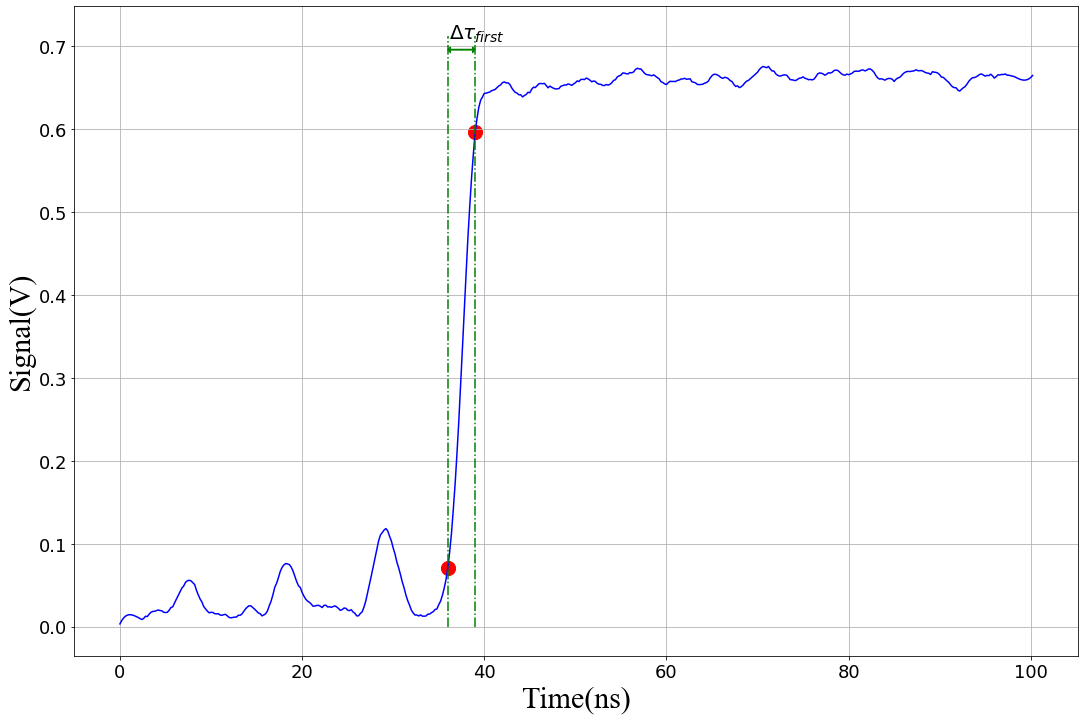

In [603]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(f_detect_time * time_coef, f_detect_signal * ampl_coef, c = 'blue') 
ax.set_xlabel('Time(ns)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Signal(V)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)

for i in range(2):
    ax.vlines(vlines[i][0] * time_coef, ymin = vlines[i][1] * ampl_coef, 
              ymax = vlines[i][2] * ampl_coef, color = 'green', linestyles = 'dashdot'
             )
ax.arrow(
          arrow[0][0] * time_coef,  arrow[0][1] * ampl_coef, + arrow[0][2] * time_coef, 0,
          head_width=arrow_head_width * ampl_coef, head_length=arrow[0][3] * time_coef, color = 'g'
            )
ax.arrow(
          arrow[0][0] * time_coef,  arrow[0][1] * ampl_coef, -arrow[0][2] * time_coef, 0,
          head_width=arrow_head_width * ampl_coef, head_length=arrow[0][3] * time_coef, color = 'g'
            )

ax.scatter(f_detect_time_01*time_coef, f_detect_signal_01*ampl_coef, color='r', s=200, marker='o')
ax.scatter(f_detect_time_09*time_coef, f_detect_signal_09*ampl_coef, color='r', s=200, marker='o')

ax.text(arrow[0][4] * time_coef,arrow[0][5] * ampl_coef, "$Δτ_{first}$ ", fontsize = 20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=18)
ax.grid()
plt.savefig(save_path + "\\" + "rise_first_detector.jpg")

### Определим время нарастания фронта импульсов от 10% до 90% на втором фотоприёмнике

In [604]:
s_detect_time,s_detect_signal = unpack(data_path, "rise_second_detector.txt", delimiter=',')
#сдвинем на 0
s_detect_time = s_detect_time - s_detect_time[0]
s_detect_signal = s_detect_signal - s_detect_signal.min()

У этого приёмника весьма маленькое время релаксации, поэтому найти максимум, усреднив последние точки, не получится 

prominence нужно подобрать так, чтобы функция давала только один пик 

In [605]:
max_s_detect_time, max_s_detect_signal, max_s_detect_ind = find_max(
                                                                    [s_detect_time,s_detect_signal], 
                                                                    prominence=0.01,
                                                                    distance=10)

Из-за малого количества точек, время нарастания фронта придется определять вручную, однако на графике все обозначения будут выставлены на правильных уровнях

In [606]:
rise_s_detect = max_s_detect_time - s_detect_time[max_s_detect_ind-2]
Delta_rise_s_detect = eps *rise_s_detect
delta_rise_s_detect = eps
print("Время нарастания импульса = ", rise_s_detect)
print("Абсолютная погрешность = ", Delta_rise_s_detect)
print("Относительна погрешность = ", delta_rise_s_detect,"\n")

Время нарастания импульса =  [4.e-10]
Абсолютная погрешность =  [2.e-13]
Относительна погрешность =  0.0005 



График тоже придётся строить в полуручном режиме 

In [607]:
time_coef = 1e+9
ampl_coef = 1e+3
level_01 = 0.1 * max_s_detect_signal 
level_09 = 0.9 * max_s_detect_signal
arrow_head_width = 5e-4
arrow_width = 1e-4
arrow_center = (
                ((s_detect_time[max_s_detect_ind-1]+0.15e-9) + (s_detect_time[max_s_detect_ind-2]-0.11e-9))/2
                )[0]
arrow_high = 1.05* max_s_detect_signal[0]
arrow_length = (((s_detect_time[max_s_detect_ind-1]+0.15e-9) - (s_detect_time[max_s_detect_ind-2]-0.11e-9))/2*0.8)[0]
arrow_head_length = (0.2*(((s_detect_time[max_s_detect_ind-1]+0.15e-9) - (s_detect_time[max_s_detect_ind-2]-0.11e-9))/2))[0]


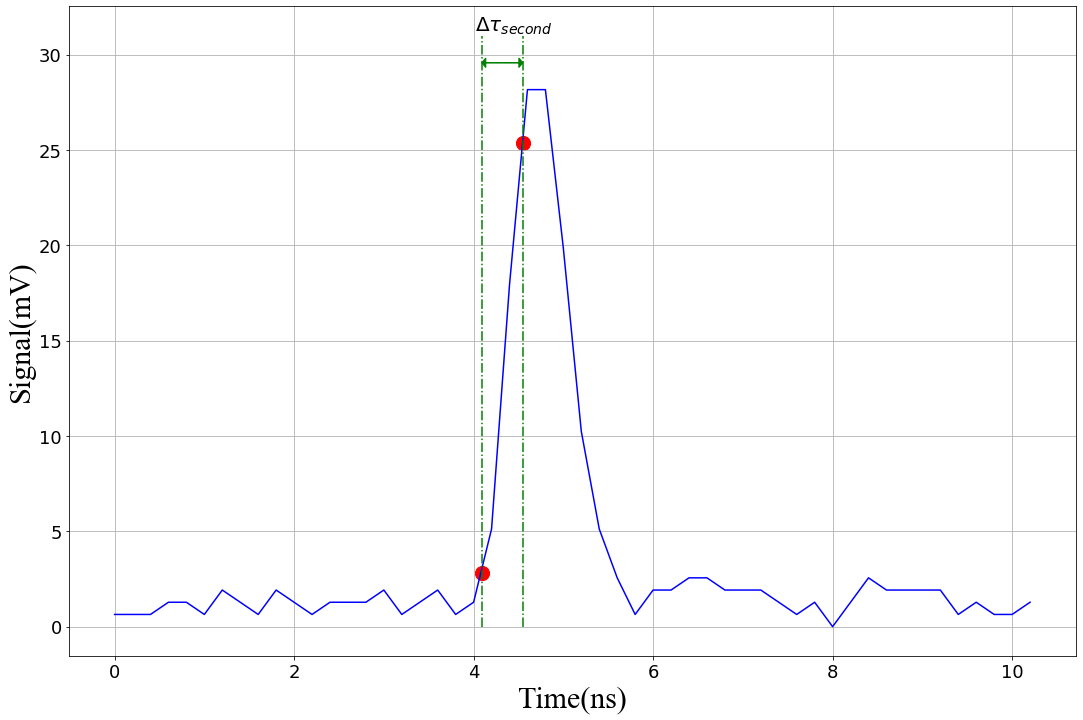

In [608]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.plot(s_detect_time * time_coef, s_detect_signal * ampl_coef, c = 'blue') 
ax.set_xlabel('Time(ns)',{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.set_ylabel("Signal(mV)",{'fontname':'Times New Roman'},fontweight='light',color='k', fontsize=30)
ax.vlines((s_detect_time[max_s_detect_ind-1]+0.15e-9) * time_coef, ymin = 0, 
          ymax =max_s_detect_signal *1.1* ampl_coef, color = 'green', linestyles = 'dashdot'
             )
ax.vlines((s_detect_time[max_s_detect_ind-2]-0.11e-9) * time_coef, ymin = 0, 
          ymax =max_s_detect_signal *1.1* ampl_coef, color = 'green', linestyles = 'dashdot'
             )

ax.arrow(
          arrow_center * time_coef,  arrow_high * ampl_coef, + arrow_length * time_coef, 0,
          head_width=arrow_head_width * ampl_coef, head_length=arrow_head_length * time_coef, color = 'g',width = arrow_width
            )
ax.arrow(
          arrow_center * time_coef,  arrow_high * ampl_coef, -arrow_length * time_coef, 0,
          head_width=arrow_head_width * ampl_coef, head_length=arrow_head_length * time_coef, color = 'g',width = arrow_width
            )

ax.scatter((s_detect_time[max_s_detect_ind-1]+0.15e-9)*time_coef, level_09*ampl_coef, color='r', s=200, marker='o')
ax.scatter((s_detect_time[max_s_detect_ind-2]-0.11e-9)*time_coef, level_01*ampl_coef, color='r', s=200, marker='o')

# ax.text(arrow[0][4] * time_coef,arrow[0][5] * ampl_coef, "$Δτ_{first}$ ", fontsize = 20)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=18)
ax.text((arrow_center-0.30e-9)*time_coef,  max_s_detect_signal*1.11 * ampl_coef, "$Δτ_{second}$ ", fontsize = 20)
ax.grid()
plt.savefig(save_path + "\\" + "rise_second_detector.jpg")